the splitseq pipeline is crashing trying to post star summary qc metrics. why?


In [1]:
import pandas
import logging
import os
import sys
from pathlib import Path
import yaml

In [2]:
WRS = str(Path("~/proj/woldlab-rna-seq").expanduser())
if WRS not in sys.path:
    sys.path.append(WRS)
from woldrnaseq.models import (
    load_star_solo_quality_metric,
)

In [25]:
EC = str(Path("~/proj/encoded_client").expanduser())

if EC not in sys.path:
    sys.path.append(EC)
from encoded_client.encoded import ENCODED, make_attachment, DCCValidator, HTTPError

server = ENCODED("test.encodedcc.org")

In [4]:
project_root = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/").expanduser()
TSTLB945896 = project_root/ "production/splitseq/TSTLB945876"

In [5]:
os.chdir(TSTLB945896)

In [12]:
SOLO_ROOT = Path("Solo.out")
with open("config.yaml", "rt") as instream:
    config = yaml.load(instream, Loader=yaml.SafeLoader)
    config["alignment_step_run"] = "barbara-wold:starsolo-split-alignment-step-run"
    config["quantification_step_run"] = "barbara-wold:starsolo-split-quantification-step-run"

def prepare_star_solo_qc(config, metric_of, filename, umi_plot):
    summary = load_star_solo_quality_metric(filename)

    star_solo_metrics = {
        "assay_term_name": "single-cell RNA sequencing assay",
        "barcode_rank_plot": make_attachment(umi_plot),
        "estimated_number_of_cells": summary["Estimated Number of Cells"],
        "fraction_of_unique_reads_in_cells": summary["Fraction of Unique Reads in Cells"],
        "mean_UMI_per_cell": summary["Mean UMI per Cell"],
        "mean_reads_per_cell": summary["Mean Reads per Cell"],
        "median_UMI_per_cell": summary["Median UMI per Cell"],
        "median_reads_per_cell": summary["Median Reads per Cell"],
        "number_of_reads": summary["Number of Reads"],
        "q30_bases_in_CB_UMI": summary["Q30 Bases in CB+UMI"],
        "q30_bases_in_rna_read": summary["Q30 Bases in RNA read"],
        "reads_mapped_to_genome_unique": summary["Reads Mapped to Genome: Unique"],
        "reads_mapped_to_genome_unique_and_multiple": summary["Reads Mapped to Genome: Unique+Multiple"],
        "reads_with_valid_barcodes": summary["Reads With Valid Barcodes"],
        "sequencing_saturation": summary["Sequencing Saturation"],
        "umis_in_cells": summary["UMIs in Cells"],

        # run parameters not from the log file
        "quality_metric_of": metric_of,
        "step_run": config["quantification_step_run"],
        "lab": config["lab"],
        "award": config["award"],
    }

    if "Mean Gene per Cell" in summary:
        star_solo_metrics.update({
            "mode": "Gene",
            "reads_mapped_to_gene_unique_and_multiple_gene": summary["Reads Mapped to Gene: Unique+Multiple Gene"],
            "reads_mapped_to_gene_unique_gene": summary["Reads Mapped to Gene: Unique Gene"],
            "unique_reads_in_cells_mapped_to_gene": summary["Unique Reads in Cells Mapped to Gene"],
            "mean_gene_per_cell": summary["Mean Gene per Cell"],
            "median_gene_per_cell": summary["Median Gene per Cell"],
            "total_gene_detected": summary["Total Gene Detected"],
        })
    elif "Mean GeneFull_Ex50pAS per Cell" in summary:
        star_solo_metrics.update({
            "mode": "GeneFull_Ex50pAS",
            "reads_mapped_to_genefull_ex50pas_unique_and_multiple_gene_ex50pas": summary["Reads Mapped to GeneFull_Ex50pAS: Unique+Multiple GeneFull_Ex50pAS"],
            "reads_mapped_to_genefull_ex50pas_unique_genefull_ex50pas": summary["Reads Mapped to GeneFull_Ex50pAS: Unique GeneFull_Ex50pAS"],
            "unique_reads_in_cells_mapped_to_genefull_ex50pas": summary["Unique Reads in Cells Mapped to GeneFull_Ex50pAS"],
            "mean_genefull_ex50pas_per_cell": summary["Mean GeneFull_Ex50pAS per Cell"],
            "median_genefull_ex50pas_per_cell": summary["Median GeneFull_Ex50pAS per Cell"],
            "total_genefull_ex50pas_detected": summary["Total GeneFull_Ex50pAS Detected"],
        })
    elif "Mean GeneFull_Ex50pAS per Cell" in summary:
        star_solo_metrics.update({
            "mode": "GeneFull",
            "reads_mapped_to_genefull_unique_and_multiple_genefull": summary["Reads Mapped to GeneFull: Unique+Multiple GeneFull"],
            "reads_mapped_to_genefull_unique_genefull": summary["Reads Mapped to GeneFull: Unique GeneFull"],
            "unique_reads_in_cells_mapped_to_genefull": summary["Unique Reads in Cells Mapped to GeneFull"],
            "mean_genefull_per_cell": summary["Mean GeneFull_Ex50pAS per Cell"],
            "median_genefull_per_cell": summary["Median GeneFull_Ex50pAS per Cell"],
            "total_genefull_detected": summary["Total GeneFull_Ex50pAS Detected"],
        })
    else:
        raise ValueError("Unknown mode? {}".format(sorted(summary.keys())))

    return star_solo_metrics

def get_gene_model():
    return "GeneFull_Ex50pAS"
def get_summary_csv_path():
    return str(SOLO_ROOT / get_gene_model() / "Summary.csv")


logger = logging.getLogger("post_star_solo_qc")
logger.setLevel(logging.INFO)

uploaded = pandas.read_csv("posted.{}.csv".format(server.server))
accession = uploaded[uploaded["file_format"] == "bam"]["accession"].to_list()
assert not pandas.isnull(accession)
qc = prepare_star_solo_qc(config, accession, get_summary_csv_path(), "umi_per_cell.png")
try:
    validator = DCCValidator(server)
    validator.validate(qc, "star_solo_quality_metric")
    #results = server.post_json("/star_solo_quality_metric/", qc)
    print()
    #with open(output[0], "wt") as outstream:
    #    outstream.write(str(results))
except Exception as e:
    logger.error(e)
    raise e


In [10]:
uploaded[uploaded["file_format"] == "bam"]

,uuid,accession,dataset,file_format,output_type,assembly,genome_annotation,derived_from:array,md5sum,file_size:integer,...,step_run,aliases:array,"(0, 'accession')","(0, 'uuid')","(1, 'accession')","(1, 'uuid')","(2, 'accession')","(2, 'uuid')","(3, 'accession')","(3, 'uuid')"
0,NaN,NaN,TSTSR521131,bam,alignments,mm10,M21,"encode:starsolo-mm10-M21-male-index,/files/TST...",ad2d09c29c081c884436be01f3394bc7,878521717,...,barbara-wold:starsolo-split-alignment-step-run,barbara-wold:TSTLB945876_alignment_2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


{'assay_term_name': 'single-cell RNA sequencing assay',
 'total_counts_vs_pct_mitochondria': {'download': 'pct_count_mt.GeneFull_Ex50pAS_EM_raw.png',
  'type': 'image/png',
  'href': '',
  'md5sum': 'bc58cbd3d7eeca655e5da35699bf0ff2'},
 'total_counts_vs_genes_by_count': {'download': 'n_genes_by_counts.GeneFull_Ex50pAS_EM_raw.png',
  'type': 'image/png',
  'href': '',
  'md5sum': 'd8b7b77714ed8ff7e08fa7c049551758'},
 'counts_violin_plot': {'download': 'qc_metric_violin.GeneFull_Ex50pAS_EM_raw.png',
  'type': 'image/png',
  'href': '',
  'md5sum': '10d2f87a62fc7f59aab7603826776b59'},
 'quality_metric_of': ['TSTFF732693'],
 'step_run': 'barbara-wold:starsolo-split-quantification-step-run',
 'lab': '/labs/barbara-wold/',
 'award': 'UM1HG009443'}
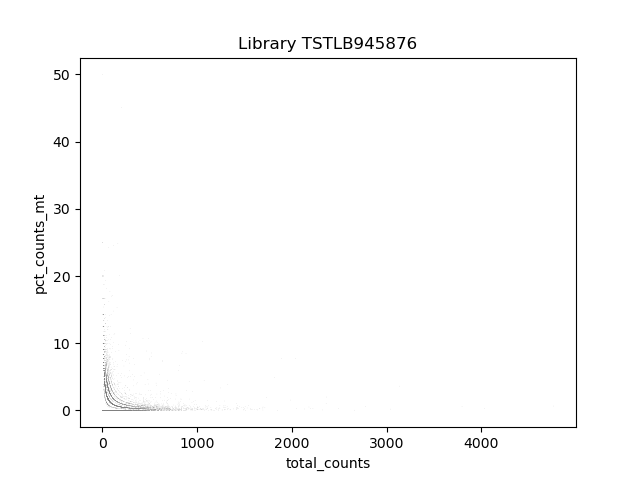
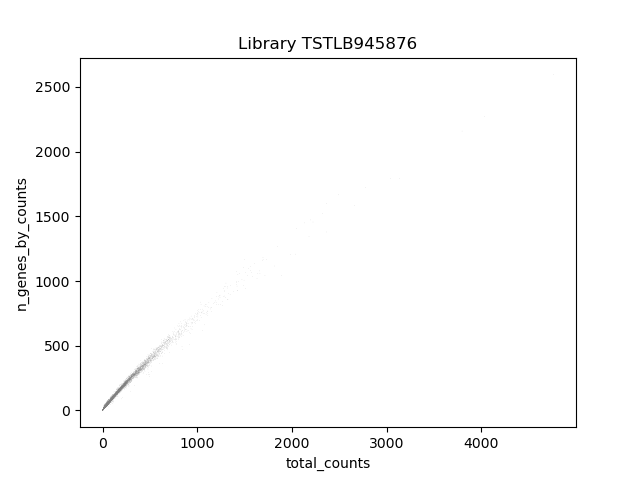
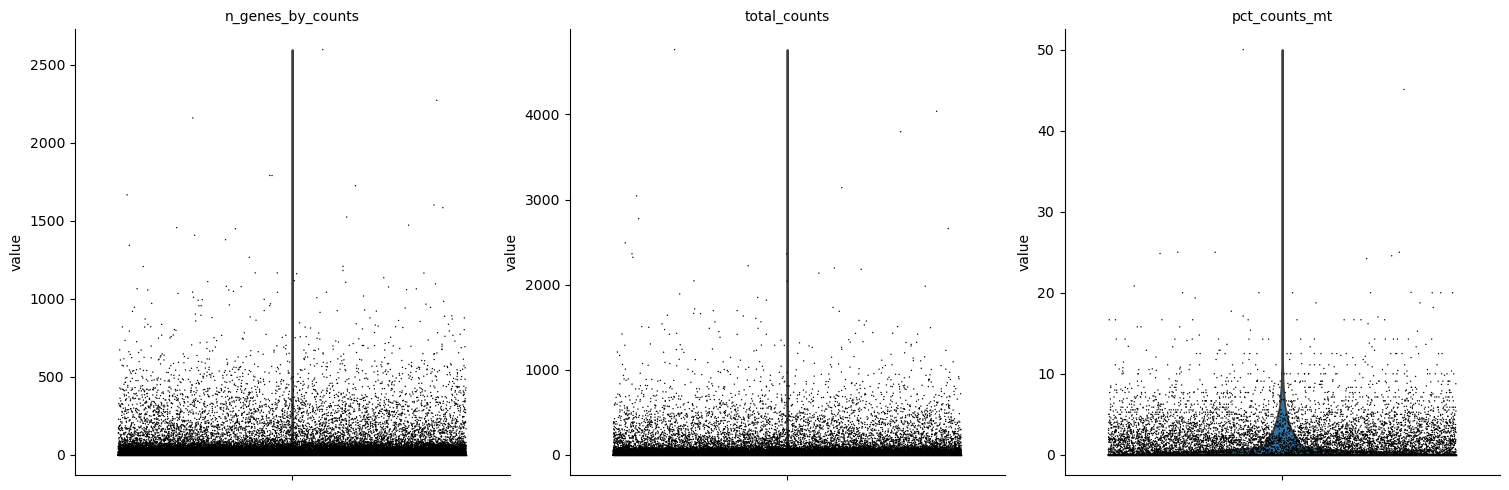

In [19]:
filename_to_output_type = {
    "Aligned.sortedByCoord.out.bam": "alignments",
    "Gene_Unique_filtered.tar.gz": "sparse gene count matrix of unique reads",
    "Gene_EM_filtered.tar.gz": "sparse gene count matrix of all reads",
    "Gene_Unique_raw.tar.gz": "unfiltered sparse gene count matrix of unique reads",
    "Gene_EM_raw.tar.gz": "unfiltered sparse gene count matrix of all reads",
    "GeneFull_Ex50pAS_Unique_filtered.tar.gz": "sparse gene count matrix of unique reads",
    "GeneFull_Ex50pAS_EM_filtered.tar.gz": "sparse gene count matrix of all reads",
    "GeneFull_Ex50pAS_Unique_raw.tar.gz": "unfiltered sparse gene count matrix of unique reads",
    "GeneFull_Ex50pAS_EM_raw.tar.gz": "unfiltered sparse gene count matrix of all reads",
    "SJ_Unique_raw.tar.gz": "unfiltered sparse splice junction count matrix of unique reads",
}

def prepare_sc_count_matrix_qc_metric(config, metric_of, pct_mt_plot, gene_by_count_plot, genes_by_count_plot):
    sc_count_metric = {
        "assay_term_name": "single-cell RNA sequencing assay",
        "total_counts_vs_pct_mitochondria": make_attachment(pct_mt_plot),
        "total_counts_vs_genes_by_count": make_attachment(gene_by_count_plot),
        "counts_violin_plot": make_attachment(genes_by_count_plot),

        # run parameters not from the log file
        "quality_metric_of": metric_of,
        "step_run": config["quantification_step_run"],
        "lab": config["lab"],
        "award": config["award"],
    }
    return sc_count_metric

wildcards = {
    "gene_model": get_gene_model(),
    "multiread": "EM",
    "matrix": "raw"
}
pct_mt_plot = "pct_count_mt.{gene_model}_{multiread}_{matrix}.png".format(**wildcards)
genes_by_count_plot = "n_genes_by_counts.{gene_model}_{multiread}_{matrix}.png".format(**wildcards)
counts_violin_plot = "qc_metric_violin.{gene_model}_{multiread}_{matrix}.png".format(**wildcards)

logger = logging.getLogger("post_count_matrix_qc")
logger.setLevel(logging.INFO)

uploaded = pandas.read_csv("posted.{}.csv".format(server.server))
output_type = filename_to_output_type["{}_EM_{}.tar.gz".format(get_gene_model(), "raw")]
accession = uploaded[uploaded["output_type"] == output_type]["accession"].to_list()
assert not pandas.isnull(accession)
qc = prepare_sc_count_matrix_qc_metric(
    config,
    accession,
    pct_mt_plot,
    genes_by_count_plot,
    counts_violin_plot
)
try:
    validator = DCCValidator(server)
    validator.validate(qc, "scrna_seq_counts_summary_quality_metric")
    #results = server.post_json("/scrna_seq_counts_summary_quality_metric/", qc)
    #with open(output[0], "wt") as outstream:
    #    outstream.write(str(results))
except Exception as e:
    logger.error(e)
    raise e

qc

In [37]:
metadata = pandas.read_csv(
    "metadata.{}.csv".format(server.server),
    dtype={
        "uuid": str,
        "accession": str
    })
for i, row in metadata.iterrows():
    if pandas.isnull(row["accession"]):
        try:
            submitted_file = server.get_json("md5:{}".format(row["md5sum"]))
            print("Should update {} {}".format(i, submitted_file["accession"]))
            metadata.at[i, "accession"] = submitted_file["accession"]
            metadata.at[i, "uuid"] = submitted_file["uuid"]
            upload_file = Path("{}.{}.upload".format(row["submitted_file_name"], server.server))
            if not upload_file.exists():
                print("want to make {}".format(upload_file))
        except HTTPError as e:
            if e.response.status_code != 404:
                logger.warning("Unexpected status code {}".format(e))
metadata

Should update 0 TSTFF759848
want to make Aligned.sortedByCoord.out.bam.test.encodedcc.org.upload
Should update 1 TSTFF008486
want to make GeneFull_Ex50pAS_Unique_raw.tar.gz.test.encodedcc.org.upload
Should update 2 TSTFF265283
want to make GeneFull_Ex50pAS_EM_raw.tar.gz.test.encodedcc.org.upload
Should update 3 TSTFF218734
want to make SJ_Unique_raw.tar.gz.test.encodedcc.org.upload


,uuid,accession,dataset,file_format,output_type,assembly,genome_annotation,derived_from:array,md5sum,file_size:integer,submitted_file_name,award,lab,step_run,aliases:array
0,010708b5-cbac-492b-902b-c11185a71249,TSTFF759848,TSTSR521131,bam,alignments,mm10,M21,"encode:starsolo-mm10-M21-male-index,/files/TST...",ad2d09c29c081c884436be01f3394bc7,878521717,Aligned.sortedByCoord.out.bam,UM1HG009443,/labs/barbara-wold/,barbara-wold:starsolo-split-alignment-step-run,barbara-wold:TSTLB945876_alignment_2022-01-28
1,8857fc8f-d4ec-4cce-a804-a8f64aa41bf0,TSTFF008486,TSTSR521131,tar,unfiltered sparse gene count matrix of unique ...,mm10,M21,"encode:parse-biosciences-v1,barbara-wold:TSTLB...",88b126390c8fa25c521e9c85232474f7,7319865,GeneFull_Ex50pAS_Unique_raw.tar.gz,UM1HG009443,/labs/barbara-wold/,barbara-wold:starsolo-split-quantification-ste...,NaN
2,39579433-f686-4d46-919c-e54629721234,TSTFF265283,TSTSR521131,tar,unfiltered sparse gene count matrix of all reads,mm10,M21,"encode:parse-biosciences-v1,barbara-wold:TSTLB...",dd7674c4cceb8656cb5776dc2efe4cf0,7994516,GeneFull_Ex50pAS_EM_raw.tar.gz,UM1HG009443,/labs/barbara-wold/,barbara-wold:starsolo-split-quantification-ste...,NaN
3,24e7a8e1-5cbd-4de4-9229-d090356ce003,TSTFF218734,TSTSR521131,tar,unfiltered sparse splice junction count matrix...,mm10,M21,"encode:parse-biosciences-v1,barbara-wold:TSTLB...",4010be8b35391f6e73f34018723f139e,2654382,SJ_Unique_raw.tar.gz,UM1HG009443,/labs/barbara-wold/,barbara-wold:starsolo-split-quantification-ste...,NaN


In [34]:
metadata.iloc[0]["accession"] = "foo"

<ipython-input-34-58550ff180c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata.iloc[0]["accession"] = "foo"


In [22]:
f["uuid"]

'010708b5-cbac-492b-902b-c11185a71249'

In [36]:
metadata.dtypes

uuid                   float64
accession              float64
dataset                 object
file_format             object
output_type             object
assembly                object
genome_annotation       object
derived_from:array      object
md5sum                  object
file_size:integer        int64
submitted_file_name     object
award                   object
lab                     object
step_run                object
aliases:array           object
dtype: object

In [40]:
rep2 = pandas.read_csv(project_root / "production/splitseq/TSTSR521131/posted.test.encodedcc.org.csv")
rep2

,uuid,accession,dataset,file_format,output_type,assembly,genome_annotation,derived_from:array,md5sum,file_size:integer,submitted_file_name,award,lab,step_run,aliases:array
0,8aeb7c15-fcf3-42f8-b32e-b801f5d9f411,TSTFF134695,TSTSR521131,bam,alignments,mm10,M21,"encode:starsolo-mm10-M21-male-index,/files/TST...",108bddb9aa7900799aa6105b216d11b8,1742080312,Aligned.sortedByCoord.out.bam,UM1HG009443,/labs/barbara-wold/,barbara-wold:starsolo-split-alignment-step-run,barbara-wold:TSTLB148797_alignment_2022-01-28
1,8af6b4f6-b7a4-4a95-8ceb-294480640e8f,TSTFF701094,TSTSR521131,tar,unfiltered sparse gene count matrix of unique ...,mm10,M21,"encode:parse-biosciences-v1,barbara-wold:TSTLB...",118d26a0e8006f7a89269e2ff656dfb2,12578929,GeneFull_Ex50pAS_Unique_raw.tar.gz,UM1HG009443,/labs/barbara-wold/,barbara-wold:starsolo-split-quantification-ste...,NaN
2,36ecd78b-5d72-4c0f-93f5-8a822d2e8cfd,TSTFF246075,TSTSR521131,tar,unfiltered sparse gene count matrix of all reads,mm10,M21,"encode:parse-biosciences-v1,barbara-wold:TSTLB...",9e70eb75e7e635a73577c855d91bbdd4,13790297,GeneFull_Ex50pAS_EM_raw.tar.gz,UM1HG009443,/labs/barbara-wold/,barbara-wold:starsolo-split-quantification-ste...,NaN
3,0b0857a3-6793-4d1d-b27b-d0d3a5d2a80f,TSTFF794233,TSTSR521131,tar,unfiltered sparse splice junction count matrix...,mm10,M21,"encode:parse-biosciences-v1,barbara-wold:TSTLB...",bfe601a059d4b2f2dfa2d43560fd16ce,3628684,SJ_Unique_raw.tar.gz,UM1HG009443,/labs/barbara-wold/,barbara-wold:starsolo-split-quantification-ste...,NaN


In [41]:
output_type = filename_to_output_type["GeneFull_Ex50pAS_EM_raw.tar.gz"]
uploaded[uploaded["output_type"] == output_type]["accession"].to_list()

['TSTFF732693']